In [1]:
### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
tf.compat.v1.disable_eager_execution()

import os
import sys

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

In [2]:
def basal_topology_func(x):
    b = 1.0 - 0.1*x
    return b

def solution(nx, nt, L, T, M, basal_topology_func):

    if len(M) != nx + 1:
        raise ValueError('M specified but len(M) != nx + 1')
        
    dx = L/nx
    dt = T/nt
    x = np.linspace(0,L,nx+1)
    t = np.linspace(0,T,nt+1)

    b = basal_topology_func(x)

    A = 1e-16
    rho = 920.0
    g = 9.2 
    n = 3

    C = 2*A/(n+2) * (rho*g)**n * (1e3)**n

    h = np.zeros((nx+1,nt+1))
    H = np.zeros((nx+1,nt+1))
    h[:,0] = b
    h[0,:] = b[0]
    h[-1,:] = b[-1]

    H[:,0] = h[:,0] - b
    H[0,:] = h[0,:] - b[0]
    H[-1,:] = h[-1,:] - b[-1]

    for i in range(1,len(t)):

        D = C *((H[1:,i-1]+H[:nx,i-1])/2.0)**(n+2) * ((h[1:,i-1] - h[:nx,i-1])/dx)**(n-1)

        phi = -D*(h[1:,i-1]-h[:nx,i-1])/dx

        h[1:nx,i] = h[1:nx,i-1] + M[1:nx]*dt - dt/dx * (phi[1:]-phi[:nx-1])
        h[1:nx,i] = (h[1:nx,i] < b[1:nx]) * b[1:nx] + (h[1:nx,i] >= b[1:nx]) * h[1:nx,i]
        H[:,i] = np.maximum(h[:,i] - b, 0.)

        if not np.any(H[:,i]>=0.0):
            raise Exception("Something went wrong.")
            
    Volume = np.sum(H)*dx
    
    return H[int(nx/2),-1], h[int(nx/2),-1], Volume

L = 30.
T = 10.
nx = 300
nt = 12000
samples = 1000

M_samples = 0.01*np.random.rand(samples, nx+1)
H_samples = np.zeros((samples,1), dtype = np.float64)
Volume_samples = np.zeros((samples,1), dtype = np.float64)

for sample in range(samples):
    if (sample+1) % 100 == 0:
        print(f'Sample #{sample+1}', end='\r')
    H_samples[sample], _, Volume_samples[sample] = solution(nx, nt, L, T, M_samples[sample], basal_topology_func)

In [3]:
Layers = [{'size': nx+1, 'activation': None    , 'use_bias': None},
          {'size': 10 , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1  , 'activation': 'linear', 'use_bias': False}]
Losses = [{'kind': 'mse', 'weight': 1.0}]

K = TrainFullyConnectedNN(M_samples, H_samples, 
                    Layers, Losses,
                    'adam', ['mae'], 
                    10, 1000, 0.2, 
                    'model', os.path.abspath(''))

best_model = K.quickTrain()

Train on 800 samples, validate on 200 samples
Epoch 1/1000


2023-07-28 20:01:25.351376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/libs/gnu7/openmpi/netcdf/4.5.0/lib:/opt/ohpc/pub/libs/gnu7/openmpi/netcdf-fortran/4.4.4/lib:/opt/ohpc/pub/libs/gnu7/openmpi/hdf5/1.10.1/lib:/opt/ohpc/pub/mpi/openmpi-gnu7/1.10.7/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/home/shreyas/lis-2.1.3/installation/lib:/share/jdk-16.0.1/lib::
2023-07-28 20:01:25.351439: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-28 20:01:25.351477: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c5-3): /proc/driver/nvidia/version does not exist
2023-07-28 20:01:25.352101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural N

650/800 [=======================>......] - ETA: 0s - loss: 7.3425e-04 - mae: 0.0220
Epoch 1: val_loss improved from inf to 0.00050, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 405us/sample - loss: 6.9064e-04 - mae: 0.0215 - val_loss: 4.9767e-04 - val_mae: 0.0186
Epoch 2/1000
770/800 [===========================>..] - ETA: 0s - loss: 4.8464e-04 - mae: 0.0190
Epoch 2: val_loss improved from 0.00050 to 0.00048, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 180us/sample - loss: 4.8181e-04 - mae: 0.0190 - val_loss: 4.7527e-04 - val_mae: 0.0184
Epoch 3/1000
770/800 [===========================>..] - ETA: 0s - loss: 4.7855e-04 - mae: 0.0188
Epoch 3: val_loss improved from 0.00048 to 0.00046, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 183us/sample - loss: 4.7767e-04 - mae: 0.0188 - val_loss: 4.5597e-04 - val_mae: 0.0182
Epoch 4/1

760/800 [===========================>..] - ETA: 0s - loss: 9.6415e-05 - mae: 0.0080
Epoch 26: val_loss improved from 0.00018 to 0.00018, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 183us/sample - loss: 9.5982e-05 - mae: 0.0080 - val_loss: 1.7593e-04 - val_mae: 0.0109
Epoch 27/1000
740/800 [==========================>...] - ETA: 0s - loss: 8.8084e-05 - mae: 0.0076
Epoch 27: val_loss improved from 0.00018 to 0.00016, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 202us/sample - loss: 8.8879e-05 - mae: 0.0077 - val_loss: 1.6000e-04 - val_mae: 0.0104
Epoch 28/1000
750/800 [===========================>..] - ETA: 0s - loss: 8.2216e-05 - mae: 0.0073
Epoch 28: val_loss improved from 0.00016 to 0.00015, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 186us/sample - loss: 8.2655e-05 - mae: 0.0074 - val_loss: 1.4674e-04 - val_mae: 0.0098


800/800 [==============================] - 0s 171us/sample - loss: 2.4716e-05 - mae: 0.0040 - val_loss: 5.4152e-05 - val_mae: 0.0059
Epoch 52/1000
790/800 [============================>.] - ETA: 0s - loss: 2.7401e-05 - mae: 0.0042
Epoch 52: val_loss improved from 0.00005 to 0.00005, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 191us/sample - loss: 2.7289e-05 - mae: 0.0042 - val_loss: 5.3344e-05 - val_mae: 0.0059
Epoch 53/1000
740/800 [==========================>...] - ETA: 0s - loss: 2.5135e-05 - mae: 0.0040
Epoch 53: val_loss improved from 0.00005 to 0.00005, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 189us/sample - loss: 2.5265e-05 - mae: 0.0040 - val_loss: 5.1720e-05 - val_mae: 0.0058
Epoch 54/1000
780/800 [============================>.] - ETA: 0s - loss: 2.5446e-05 - mae: 0.0040
Epoch 54: val_loss did not improve from 0.00005
800/800 [==============================] - 0s

Epoch 79/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.7928e-05 - mae: 0.0034
Epoch 79: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 159us/sample - loss: 1.8626e-05 - mae: 0.0034 - val_loss: 4.3173e-05 - val_mae: 0.0054
Epoch 80/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.8857e-05 - mae: 0.0034
Epoch 80: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 161us/sample - loss: 1.9468e-05 - mae: 0.0035 - val_loss: 4.4289e-05 - val_mae: 0.0055
Epoch 81/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.9533e-05 - mae: 0.0035
Epoch 81: val_loss improved from 0.00004 to 0.00004, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 199us/sample - loss: 1.9187e-05 - mae: 0.0035 - val_loss: 3.8939e-05 - val_mae: 0.0051
Epoch 82/1000
690/800 [========================>.....] - ETA: 0s - loss: 2.0515e-05 - mae: 0.0036
Epoch 

760/800 [===========================>..] - ETA: 0s - loss: 1.9274e-05 - mae: 0.0035
Epoch 107: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 157us/sample - loss: 1.9121e-05 - mae: 0.0035 - val_loss: 4.0022e-05 - val_mae: 0.0052
Epoch 108/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.9436e-05 - mae: 0.0035
Epoch 108: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 2.0392e-05 - mae: 0.0036 - val_loss: 3.9107e-05 - val_mae: 0.0052
Epoch 109/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.8466e-05 - mae: 0.0034
Epoch 109: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 1.8628e-05 - mae: 0.0034 - val_loss: 3.9751e-05 - val_mae: 0.0052
Epoch 110/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.8463e-05 - mae: 0.0034
Epoch 110: val_loss did not improve from 0.00004
800/800 [===============

650/800 [=======================>......] - ETA: 0s - loss: 1.8011e-05 - mae: 0.0033
Epoch 136: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 181us/sample - loss: 1.8267e-05 - mae: 0.0034 - val_loss: 3.9155e-05 - val_mae: 0.0052
Epoch 137/1000
680/800 [========================>.....] - ETA: 0s - loss: 2.0494e-05 - mae: 0.0036
Epoch 137: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 178us/sample - loss: 2.0526e-05 - mae: 0.0036 - val_loss: 4.2154e-05 - val_mae: 0.0053
Epoch 138/1000
660/800 [=======================>......] - ETA: 0s - loss: 1.8546e-05 - mae: 0.0034
Epoch 138: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 188us/sample - loss: 1.8672e-05 - mae: 0.0034 - val_loss: 3.9675e-05 - val_mae: 0.0052
Epoch 139/1000
680/800 [========================>.....] - ETA: 0s - loss: 1.9786e-05 - mae: 0.0035
Epoch 139: val_loss did not improve from 0.00004
800/800 [===============

720/800 [==========================>...] - ETA: 0s - loss: 2.2464e-05 - mae: 0.0039
Epoch 165: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 169us/sample - loss: 2.2467e-05 - mae: 0.0039 - val_loss: 4.4718e-05 - val_mae: 0.0055
Epoch 166/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.8581e-05 - mae: 0.0034
Epoch 166: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 166us/sample - loss: 1.9216e-05 - mae: 0.0035 - val_loss: 3.9489e-05 - val_mae: 0.0052
Epoch 167/1000
730/800 [==========================>...] - ETA: 0s - loss: 2.0404e-05 - mae: 0.0036
Epoch 167: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 173us/sample - loss: 2.0139e-05 - mae: 0.0036 - val_loss: 4.6787e-05 - val_mae: 0.0056
Epoch 168/1000
670/800 [========================>.....] - ETA: 0s - loss: 1.9005e-05 - mae: 0.0035
Epoch 168: val_loss did not improve from 0.00004
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 1.5572e-05 - mae: 0.0031
Epoch 194: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 1.9845e-05 - mae: 0.0035 - val_loss: 3.8872e-05 - val_mae: 0.0051
Epoch 195/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.6917e-05 - mae: 0.0033
Epoch 195: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 131us/sample - loss: 1.7939e-05 - mae: 0.0033 - val_loss: 3.8805e-05 - val_mae: 0.0051
Epoch 196/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.7910e-05 - mae: 0.0034
Epoch 196: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 133us/sample - loss: 1.8392e-05 - mae: 0.0034 - val_loss: 4.0666e-05 - val_mae: 0.0052
Epoch 197/1000
440/800 [===============>..............] - ETA: 0s - loss: 2.0023e-05 - mae: 0.0035
Epoch 197: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 2.3457e-05 - mae: 0.0039
Epoch 223: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 2.1318e-05 - mae: 0.0037 - val_loss: 3.8881e-05 - val_mae: 0.0051
Epoch 224/1000
400/800 [==============>...............] - ETA: 0s - loss: 1.8051e-05 - mae: 0.0034
Epoch 224: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.8749e-05 - mae: 0.0034 - val_loss: 3.9248e-05 - val_mae: 0.0052
Epoch 225/1000
460/800 [================>.............] - ETA: 0s - loss: 2.1043e-05 - mae: 0.0036
Epoch 225: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 131us/sample - loss: 2.1112e-05 - mae: 0.0037 - val_loss: 4.0117e-05 - val_mae: 0.0052
Epoch 226/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.9685e-05 - mae: 0.0035
Epoch 226: val_loss did not improve from 0.00004
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.5644e-05 - mae: 0.0032
Epoch 252: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 135us/sample - loss: 1.7484e-05 - mae: 0.0033 - val_loss: 3.9221e-05 - val_mae: 0.0052
Epoch 253/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.8775e-05 - mae: 0.0034
Epoch 253: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 136us/sample - loss: 1.8226e-05 - mae: 0.0034 - val_loss: 4.3624e-05 - val_mae: 0.0054
Epoch 254/1000
460/800 [================>.............] - ETA: 0s - loss: 1.9422e-05 - mae: 0.0035
Epoch 254: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 131us/sample - loss: 1.8993e-05 - mae: 0.0034 - val_loss: 3.9798e-05 - val_mae: 0.0051
Epoch 255/1000
440/800 [===============>..............] - ETA: 0s - loss: 2.1771e-05 - mae: 0.0037
Epoch 255: val_loss did not improve from 0.00004
800/800 [===============

470/800 [================>.............] - ETA: 0s - loss: 1.6980e-05 - mae: 0.0032
Epoch 281: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.9367e-05 - mae: 0.0035 - val_loss: 3.8898e-05 - val_mae: 0.0051
Epoch 282/1000
800/800 [==============================] - ETA: 0s - loss: 1.8032e-05 - mae: 0.0034
Epoch 282: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 151us/sample - loss: 1.8032e-05 - mae: 0.0034 - val_loss: 3.9154e-05 - val_mae: 0.0051
Epoch 283/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.5954e-05 - mae: 0.0031
Epoch 283: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.7513e-05 - mae: 0.0033 - val_loss: 3.9943e-05 - val_mae: 0.0052
Epoch 284/1000
460/800 [================>.............] - ETA: 0s - loss: 1.8347e-05 - mae: 0.0034
Epoch 284: val_loss did not improve from 0.00004
800/800 [===============

760/800 [===========================>..] - ETA: 0s - loss: 1.8295e-05 - mae: 0.0034
Epoch 310: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 165us/sample - loss: 1.8355e-05 - mae: 0.0034 - val_loss: 4.0596e-05 - val_mae: 0.0053
Epoch 311/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.8684e-05 - mae: 0.0034
Epoch 311: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 168us/sample - loss: 1.8322e-05 - mae: 0.0034 - val_loss: 3.8567e-05 - val_mae: 0.0051
Epoch 312/1000
730/800 [==========================>...] - ETA: 0s - loss: 2.0338e-05 - mae: 0.0036
Epoch 312: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 162us/sample - loss: 2.0256e-05 - mae: 0.0036 - val_loss: 4.0031e-05 - val_mae: 0.0052
Epoch 313/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.7566e-05 - mae: 0.0033
Epoch 313: val_loss did not improve from 0.00004
800/800 [===============

720/800 [==========================>...] - ETA: 0s - loss: 1.8315e-05 - mae: 0.0034
Epoch 339: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 162us/sample - loss: 1.9237e-05 - mae: 0.0034 - val_loss: 4.9379e-05 - val_mae: 0.0057
Epoch 340/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.7528e-05 - mae: 0.0034
Epoch 340: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 136us/sample - loss: 1.8278e-05 - mae: 0.0034 - val_loss: 4.2994e-05 - val_mae: 0.0054
Epoch 341/1000
490/800 [=================>............] - ETA: 0s - loss: 1.7840e-05 - mae: 0.0033
Epoch 341: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 133us/sample - loss: 1.9816e-05 - mae: 0.0035 - val_loss: 4.7506e-05 - val_mae: 0.0056
Epoch 342/1000
480/800 [=================>............] - ETA: 0s - loss: 1.8892e-05 - mae: 0.0035
Epoch 342: val_loss did not improve from 0.00004
800/800 [===============

400/800 [==============>...............] - ETA: 0s - loss: 1.9289e-05 - mae: 0.0035
Epoch 368: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 1.9432e-05 - mae: 0.0035 - val_loss: 3.9289e-05 - val_mae: 0.0051
Epoch 369/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.9501e-05 - mae: 0.0035
Epoch 369: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 1.9513e-05 - mae: 0.0035 - val_loss: 3.9352e-05 - val_mae: 0.0052
Epoch 370/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.7013e-05 - mae: 0.0032
Epoch 370: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 1.7286e-05 - mae: 0.0033 - val_loss: 3.8860e-05 - val_mae: 0.0051
Epoch 371/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.7759e-05 - mae: 0.0033
Epoch 371: val_loss did not improve from 0.00004
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.8839e-05 - mae: 0.0034
Epoch 397: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 133us/sample - loss: 2.1246e-05 - mae: 0.0037 - val_loss: 4.3344e-05 - val_mae: 0.0053
Epoch 398/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.9432e-05 - mae: 0.0035
Epoch 398: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 131us/sample - loss: 2.0327e-05 - mae: 0.0035 - val_loss: 4.0692e-05 - val_mae: 0.0052
Epoch 399/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.6622e-05 - mae: 0.0032
Epoch 399: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 1.7691e-05 - mae: 0.0033 - val_loss: 3.9283e-05 - val_mae: 0.0052
Epoch 400/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.8916e-05 - mae: 0.0034
Epoch 400: val_loss did not improve from 0.00004
800/800 [===============

460/800 [================>.............] - ETA: 0s - loss: 1.7682e-05 - mae: 0.0034
Epoch 426: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 130us/sample - loss: 1.9136e-05 - mae: 0.0035 - val_loss: 3.8845e-05 - val_mae: 0.0051
Epoch 427/1000
490/800 [=================>............] - ETA: 0s - loss: 1.9143e-05 - mae: 0.0034
Epoch 427: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 126us/sample - loss: 1.8903e-05 - mae: 0.0034 - val_loss: 4.4749e-05 - val_mae: 0.0054
Epoch 428/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.8616e-05 - mae: 0.0034
Epoch 428: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 2.0257e-05 - mae: 0.0036 - val_loss: 6.7072e-05 - val_mae: 0.0067
Epoch 429/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.9663e-05 - mae: 0.0035
Epoch 429: val_loss did not improve from 0.00004
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.7719e-05 - mae: 0.0034
Epoch 455: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 136us/sample - loss: 1.8295e-05 - mae: 0.0034 - val_loss: 4.8679e-05 - val_mae: 0.0057
Epoch 456/1000
470/800 [================>.............] - ETA: 0s - loss: 1.9244e-05 - mae: 0.0034
Epoch 456: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 129us/sample - loss: 1.9204e-05 - mae: 0.0034 - val_loss: 3.9942e-05 - val_mae: 0.0052
Epoch 457/1000
470/800 [================>.............] - ETA: 0s - loss: 1.9215e-05 - mae: 0.0034
Epoch 457: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 134us/sample - loss: 1.8578e-05 - mae: 0.0034 - val_loss: 3.8519e-05 - val_mae: 0.0051
Epoch 458/1000
460/800 [================>.............] - ETA: 0s - loss: 1.7985e-05 - mae: 0.0033
Epoch 458: val_loss did not improve from 0.00004
800/800 [===============

770/800 [===========================>..] - ETA: 0s - loss: 1.7880e-05 - mae: 0.0034
Epoch 484: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 160us/sample - loss: 1.7627e-05 - mae: 0.0033 - val_loss: 4.2471e-05 - val_mae: 0.0054
Epoch 485/1000
800/800 [==============================] - ETA: 0s - loss: 2.2179e-05 - mae: 0.0038
Epoch 485: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 151us/sample - loss: 2.2179e-05 - mae: 0.0038 - val_loss: 4.0221e-05 - val_mae: 0.0051
Epoch 486/1000
410/800 [==============>...............] - ETA: 0s - loss: 2.0422e-05 - mae: 0.0036
Epoch 486: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 1.9559e-05 - mae: 0.0035 - val_loss: 4.3585e-05 - val_mae: 0.0054
Epoch 487/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.9523e-05 - mae: 0.0034
Epoch 487: val_loss did not improve from 0.00004
800/800 [===============

410/800 [==============>...............] - ETA: 0s - loss: 1.8103e-05 - mae: 0.0033
Epoch 513: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 1.8462e-05 - mae: 0.0034 - val_loss: 3.9782e-05 - val_mae: 0.0051
Epoch 514/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.8075e-05 - mae: 0.0034
Epoch 514: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.7770e-05 - mae: 0.0033 - val_loss: 4.4299e-05 - val_mae: 0.0055
Epoch 515/1000
460/800 [================>.............] - ETA: 0s - loss: 1.9936e-05 - mae: 0.0035
Epoch 515: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 132us/sample - loss: 1.8368e-05 - mae: 0.0034 - val_loss: 4.1759e-05 - val_mae: 0.0052
Epoch 516/1000
470/800 [================>.............] - ETA: 0s - loss: 2.1427e-05 - mae: 0.0036
Epoch 516: val_loss did not improve from 0.00004
800/800 [===============

740/800 [==========================>...] - ETA: 0s - loss: 1.8731e-05 - mae: 0.0034
Epoch 542: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 160us/sample - loss: 1.8794e-05 - mae: 0.0034 - val_loss: 3.9173e-05 - val_mae: 0.0052
Epoch 543/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.6792e-05 - mae: 0.0033
Epoch 543: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.7235e-05 - mae: 0.0033 - val_loss: 4.0224e-05 - val_mae: 0.0052
Epoch 544/1000
420/800 [==============>...............] - ETA: 0s - loss: 2.0105e-05 - mae: 0.0036
Epoch 544: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 152us/sample - loss: 1.8824e-05 - mae: 0.0035 - val_loss: 3.9447e-05 - val_mae: 0.0051
Epoch 545/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.7830e-05 - mae: 0.0033
Epoch 545: val_loss did not improve from 0.00004
800/800 [===============

410/800 [==============>...............] - ETA: 0s - loss: 1.7686e-05 - mae: 0.0033
Epoch 571: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 1.7657e-05 - mae: 0.0033 - val_loss: 3.8389e-05 - val_mae: 0.0051
Epoch 572/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.6662e-05 - mae: 0.0032
Epoch 572: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 1.7803e-05 - mae: 0.0034 - val_loss: 3.9410e-05 - val_mae: 0.0052
Epoch 573/1000
780/800 [============================>.] - ETA: 0s - loss: 1.8344e-05 - mae: 0.0034
Epoch 573: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 157us/sample - loss: 1.8786e-05 - mae: 0.0034 - val_loss: 5.4866e-05 - val_mae: 0.0060
Epoch 574/1000
390/800 [=============>................] - ETA: 0s - loss: 1.9551e-05 - mae: 0.0035
Epoch 574: val_loss did not improve from 0.00004
800/800 [===============

440/800 [===============>..............] - ETA: 0s - loss: 1.6713e-05 - mae: 0.0033
Epoch 600: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 136us/sample - loss: 1.8198e-05 - mae: 0.0034 - val_loss: 3.9317e-05 - val_mae: 0.0052
Epoch 601/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.7995e-05 - mae: 0.0034
Epoch 601: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 136us/sample - loss: 1.9079e-05 - mae: 0.0035 - val_loss: 3.9745e-05 - val_mae: 0.0052
Epoch 602/1000
470/800 [================>.............] - ETA: 0s - loss: 1.6861e-05 - mae: 0.0033
Epoch 602: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 133us/sample - loss: 1.8535e-05 - mae: 0.0034 - val_loss: 3.9038e-05 - val_mae: 0.0051
Epoch 603/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.7682e-05 - mae: 0.0033
Epoch 603: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.5752e-05 - mae: 0.0031
Epoch 629: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.8263e-05 - mae: 0.0034 - val_loss: 4.3284e-05 - val_mae: 0.0054
Epoch 630/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.9108e-05 - mae: 0.0035
Epoch 630: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 152us/sample - loss: 1.9490e-05 - mae: 0.0035 - val_loss: 3.8883e-05 - val_mae: 0.0051
Epoch 631/1000
400/800 [==============>...............] - ETA: 0s - loss: 1.5500e-05 - mae: 0.0032
Epoch 631: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 1.7235e-05 - mae: 0.0033 - val_loss: 4.1802e-05 - val_mae: 0.0052
Epoch 632/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.8423e-05 - mae: 0.0033
Epoch 632: val_loss did not improve from 0.00004
800/800 [===============

480/800 [=================>............] - ETA: 0s - loss: 1.8245e-05 - mae: 0.0034
Epoch 658: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 129us/sample - loss: 1.8297e-05 - mae: 0.0034 - val_loss: 4.3983e-05 - val_mae: 0.0054
Epoch 659/1000
460/800 [================>.............] - ETA: 0s - loss: 1.8456e-05 - mae: 0.0034
Epoch 659: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 132us/sample - loss: 1.8565e-05 - mae: 0.0034 - val_loss: 3.8297e-05 - val_mae: 0.0051
Epoch 660/1000
470/800 [================>.............] - ETA: 0s - loss: 1.6577e-05 - mae: 0.0032
Epoch 660: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 131us/sample - loss: 1.8046e-05 - mae: 0.0034 - val_loss: 4.2958e-05 - val_mae: 0.0054
Epoch 661/1000
470/800 [================>.............] - ETA: 0s - loss: 1.7538e-05 - mae: 0.0033
Epoch 661: val_loss did not improve from 0.00004
800/800 [===============

480/800 [=================>............] - ETA: 0s - loss: 1.5513e-05 - mae: 0.0031
Epoch 687: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 126us/sample - loss: 1.7607e-05 - mae: 0.0033 - val_loss: 3.9289e-05 - val_mae: 0.0051
Epoch 688/1000
380/800 [=============>................] - ETA: 0s - loss: 1.7994e-05 - mae: 0.0034
Epoch 688: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.7638e-05 - mae: 0.0033 - val_loss: 3.9311e-05 - val_mae: 0.0052
Epoch 689/1000
470/800 [================>.............] - ETA: 0s - loss: 1.6409e-05 - mae: 0.0032
Epoch 689: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 129us/sample - loss: 1.7464e-05 - mae: 0.0033 - val_loss: 3.8480e-05 - val_mae: 0.0051
Epoch 690/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.7317e-05 - mae: 0.0033
Epoch 690: val_loss did not improve from 0.00004
800/800 [===============

460/800 [================>.............] - ETA: 0s - loss: 1.7223e-05 - mae: 0.0033
Epoch 716: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 132us/sample - loss: 1.7739e-05 - mae: 0.0033 - val_loss: 3.9173e-05 - val_mae: 0.0051
Epoch 717/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.6818e-05 - mae: 0.0033
Epoch 717: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 137us/sample - loss: 2.0193e-05 - mae: 0.0035 - val_loss: 4.4486e-05 - val_mae: 0.0055
Epoch 718/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.7421e-05 - mae: 0.0034
Epoch 718: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 1.8126e-05 - mae: 0.0034 - val_loss: 4.0901e-05 - val_mae: 0.0053
Epoch 719/1000
460/800 [================>.............] - ETA: 0s - loss: 1.7037e-05 - mae: 0.0033
Epoch 719: val_loss did not improve from 0.00004
800/800 [===============

560/800 [====================>.........] - ETA: 0s - loss: 1.9224e-05 - mae: 0.0035
Epoch 745: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 109us/sample - loss: 1.9061e-05 - mae: 0.0035 - val_loss: 3.8497e-05 - val_mae: 0.0051
Epoch 746/1000
570/800 [====================>.........] - ETA: 0s - loss: 1.7967e-05 - mae: 0.0034
Epoch 746: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 111us/sample - loss: 1.8822e-05 - mae: 0.0034 - val_loss: 3.8995e-05 - val_mae: 0.0051
Epoch 747/1000
590/800 [=====================>........] - ETA: 0s - loss: 1.8415e-05 - mae: 0.0034
Epoch 747: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 101us/sample - loss: 1.8289e-05 - mae: 0.0033 - val_loss: 3.8461e-05 - val_mae: 0.0051
Epoch 748/1000
600/800 [=====================>........] - ETA: 0s - loss: 1.8716e-05 - mae: 0.0034
Epoch 748: val_loss did not improve from 0.00004
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.7921e-05 - mae: 0.0034
Epoch 774: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 134us/sample - loss: 1.8674e-05 - mae: 0.0034 - val_loss: 4.3191e-05 - val_mae: 0.0054
Epoch 775/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.7402e-05 - mae: 0.0033
Epoch 775: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 134us/sample - loss: 1.7548e-05 - mae: 0.0033 - val_loss: 4.0933e-05 - val_mae: 0.0052
Epoch 776/1000
480/800 [=================>............] - ETA: 0s - loss: 1.8714e-05 - mae: 0.0034
Epoch 776: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 133us/sample - loss: 1.8869e-05 - mae: 0.0035 - val_loss: 3.9588e-05 - val_mae: 0.0052
Epoch 777/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.8099e-05 - mae: 0.0033
Epoch 777: val_loss did not improve from 0.00004
800/800 [===============

470/800 [================>.............] - ETA: 0s - loss: 1.8290e-05 - mae: 0.0034
Epoch 803: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 127us/sample - loss: 1.8826e-05 - mae: 0.0034 - val_loss: 6.0585e-05 - val_mae: 0.0063
Epoch 804/1000
480/800 [=================>............] - ETA: 0s - loss: 1.9571e-05 - mae: 0.0036
Epoch 804: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 133us/sample - loss: 1.8394e-05 - mae: 0.0034 - val_loss: 3.8089e-05 - val_mae: 0.0051
Epoch 805/1000
480/800 [=================>............] - ETA: 0s - loss: 1.6912e-05 - mae: 0.0032
Epoch 805: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 130us/sample - loss: 1.7518e-05 - mae: 0.0033 - val_loss: 4.1624e-05 - val_mae: 0.0052
Epoch 806/1000
460/800 [================>.............] - ETA: 0s - loss: 1.7566e-05 - mae: 0.0033
Epoch 806: val_loss did not improve from 0.00004
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 1.7833e-05 - mae: 0.0033
Epoch 832: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 1.7046e-05 - mae: 0.0033 - val_loss: 4.1406e-05 - val_mae: 0.0052
Epoch 833/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.8556e-05 - mae: 0.0034
Epoch 833: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 164us/sample - loss: 1.8672e-05 - mae: 0.0034 - val_loss: 3.9523e-05 - val_mae: 0.0052
Epoch 834/1000
800/800 [==============================] - ETA: 0s - loss: 1.6852e-05 - mae: 0.0032
Epoch 834: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 1.6852e-05 - mae: 0.0032 - val_loss: 3.8836e-05 - val_mae: 0.0051
Epoch 835/1000
460/800 [================>.............] - ETA: 0s - loss: 1.6866e-05 - mae: 0.0032
Epoch 835: val_loss did not improve from 0.00004
800/800 [===============

470/800 [================>.............] - ETA: 0s - loss: 1.8394e-05 - mae: 0.0034
Epoch 861: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 131us/sample - loss: 1.9192e-05 - mae: 0.0035 - val_loss: 4.3400e-05 - val_mae: 0.0053
Epoch 862/1000
460/800 [================>.............] - ETA: 0s - loss: 1.9570e-05 - mae: 0.0035
Epoch 862: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 133us/sample - loss: 2.0270e-05 - mae: 0.0036 - val_loss: 3.9190e-05 - val_mae: 0.0052
Epoch 863/1000
440/800 [===============>..............] - ETA: 0s - loss: 2.1074e-05 - mae: 0.0036
Epoch 863: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 2.0136e-05 - mae: 0.0036 - val_loss: 3.8491e-05 - val_mae: 0.0051
Epoch 864/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.6351e-05 - mae: 0.0032
Epoch 864: val_loss did not improve from 0.00004
800/800 [===============

790/800 [============================>.] - ETA: 0s - loss: 1.7622e-05 - mae: 0.0033
Epoch 890: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 1.7510e-05 - mae: 0.0033 - val_loss: 3.8885e-05 - val_mae: 0.0051
Epoch 891/1000
790/800 [============================>.] - ETA: 0s - loss: 1.7452e-05 - mae: 0.0033
Epoch 891: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 155us/sample - loss: 1.7394e-05 - mae: 0.0033 - val_loss: 3.9781e-05 - val_mae: 0.0052
Epoch 892/1000
400/800 [==============>...............] - ETA: 0s - loss: 1.7019e-05 - mae: 0.0033
Epoch 892: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 1.7666e-05 - mae: 0.0033 - val_loss: 4.3293e-05 - val_mae: 0.0054
Epoch 893/1000
470/800 [================>.............] - ETA: 0s - loss: 1.7294e-05 - mae: 0.0032
Epoch 893: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.8304e-05 - mae: 0.0033
Epoch 919: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 1.8500e-05 - mae: 0.0034 - val_loss: 3.9194e-05 - val_mae: 0.0052
Epoch 920/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.5950e-05 - mae: 0.0032
Epoch 920: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.7209e-05 - mae: 0.0033 - val_loss: 3.8350e-05 - val_mae: 0.0051
Epoch 921/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.6581e-05 - mae: 0.0032
Epoch 921: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.7511e-05 - mae: 0.0033 - val_loss: 3.8109e-05 - val_mae: 0.0051
Epoch 922/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.8008e-05 - mae: 0.0033
Epoch 922: val_loss did not improve from 0.00004
800/800 [===============

470/800 [================>.............] - ETA: 0s - loss: 1.8135e-05 - mae: 0.0033
Epoch 948: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.7760e-05 - mae: 0.0033 - val_loss: 3.8657e-05 - val_mae: 0.0051
Epoch 949/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.7192e-05 - mae: 0.0033
Epoch 949: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 134us/sample - loss: 1.7850e-05 - mae: 0.0033 - val_loss: 4.0982e-05 - val_mae: 0.0053
Epoch 950/1000
480/800 [=================>............] - ETA: 0s - loss: 1.8637e-05 - mae: 0.0034
Epoch 950: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 130us/sample - loss: 1.8351e-05 - mae: 0.0034 - val_loss: 3.8521e-05 - val_mae: 0.0051
Epoch 951/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.6930e-05 - mae: 0.0033
Epoch 951: val_loss did not improve from 0.00004
800/800 [===============

700/800 [=========================>....] - ETA: 0s - loss: 1.9127e-05 - mae: 0.0034
Epoch 977: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 170us/sample - loss: 1.9044e-05 - mae: 0.0034 - val_loss: 4.1589e-05 - val_mae: 0.0053
Epoch 978/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.8497e-05 - mae: 0.0034
Epoch 978: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 157us/sample - loss: 1.8593e-05 - mae: 0.0034 - val_loss: 3.8511e-05 - val_mae: 0.0051
Epoch 979/1000
800/800 [==============================] - ETA: 0s - loss: 1.9758e-05 - mae: 0.0036
Epoch 979: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 153us/sample - loss: 1.9758e-05 - mae: 0.0036 - val_loss: 3.9394e-05 - val_mae: 0.0052
Epoch 980/1000
780/800 [============================>.] - ETA: 0s - loss: 1.7757e-05 - mae: 0.0033
Epoch 980: val_loss did not improve from 0.00004
800/800 [===============

In [4]:
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': 0.001}
X = XAIR(best_model, 'lrp.alpha_1_beta_0', 'letzgus', M_samples[:2], normalizeDict, **kwargs)
X.check_sample(M_samples[0]), X.check_sample(M_samples[1])

(array([[-4.2270403e-07]], dtype=float32),
 array([[-2.1884101e-05]], dtype=float32))

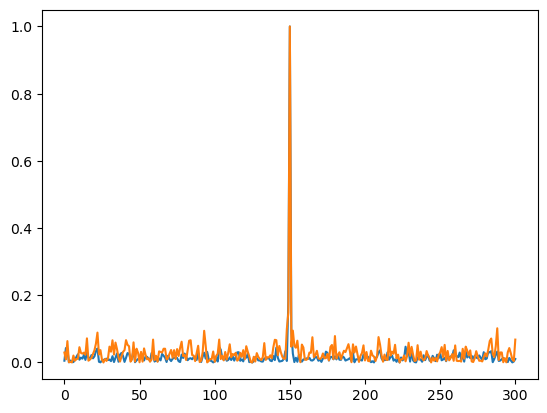

In [5]:
%matplotlib inline
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])

In [6]:
y_ref = 0.001
best_model = K.loadBestModel()
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': y_ref}
X = XAIR(best_model, 'lrp.z', 'classic', M_samples[:10], normalizeDict, **kwargs)
X.check_sample(M_samples[0]), X.check_sample(M_samples[10])

(array([[-4.2270403e-07]], dtype=float32),
 array([[-2.258073e-05]], dtype=float32))

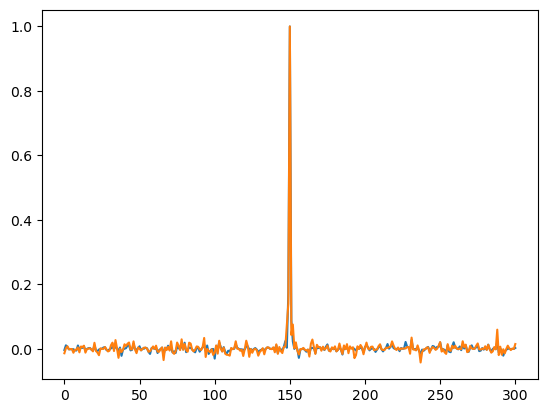

In [7]:
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])

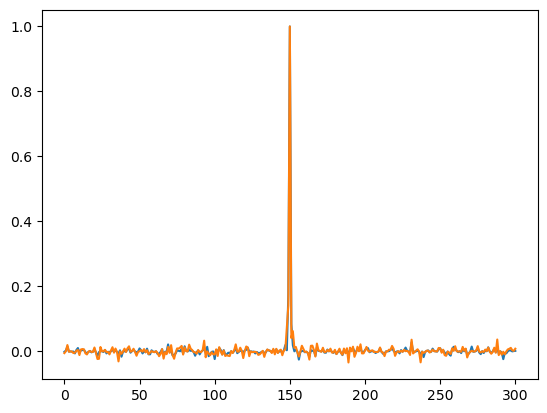

In [8]:
L = TrainLR(M_samples, H_samples, y_ref = y_ref, fit_intercept = False)
regr = L.quickTrain()

XL = XLR(regr, M_samples)
a_LR, stats_LR = XL.quick_analyze()

plt.plot(a_LR[0])
plt.plot(a_LR[1])

In [9]:
y_ref = 0.0004
best_model = K.loadBestModel()
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': y_ref}
X = XAIR(best_model, 'lrp.z', 'classic', M_samples[:10], normalizeDict, **kwargs)
X.check_sample(M_samples[0]), X.check_sample(M_samples[10])

(array([[-2.0258798e-05]], dtype=float32),
 array([[-1.9364728e-05]], dtype=float32))

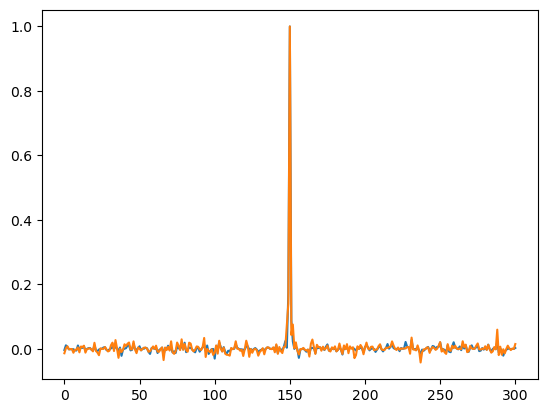

In [10]:
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])

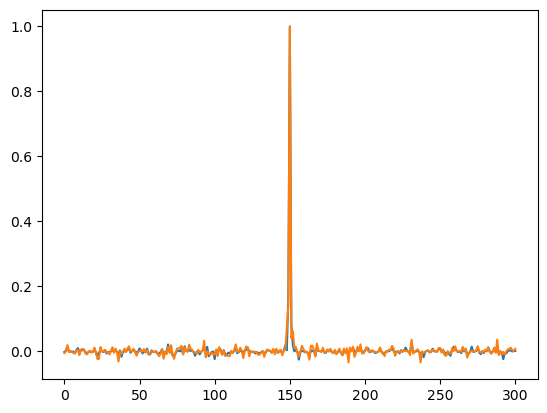

In [11]:
L = TrainLR(M_samples, H_samples, y_ref = y_ref, fit_intercept = False)
regr = L.quickTrain()

XL = XLR(regr, M_samples)
a_LR, stats_LR = XL.quick_analyze()

plt.plot(a_LR[0])
plt.plot(a_LR[1])

In [12]:
### Try one model with non-zero last layer bias

Layers = [{'size': nx+1, 'activation': None    , 'use_bias': None},
          {'size': 10 , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1  , 'activation': 'linear', 'use_bias': True}]
Losses = [{'kind': 'mse', 'weight': 1.0}]

K = TrainFullyConnectedNN(M_samples, H_samples, 
                    Layers, Losses,
                    'adam', ['mae'], 
                    10, 1000, 0.2, 
                    'model', os.path.abspath(''))

best_model = K.quickTrain()

Train on 800 samples, validate on 200 samples
Epoch 1/1000
490/800 [=================>............] - ETA: 0s - loss: 7.9643e-04 - mae: 0.0229
Epoch 1: val_loss improved from inf to 0.00047, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 298us/sample - loss: 6.8431e-04 - mae: 0.0215 - val_loss: 4.6773e-04 - val_mae: 0.0184
Epoch 2/1000
370/800 [============>.................] - ETA: 0s - loss: 4.8740e-04 - mae: 0.0188
Epoch 2: val_loss did not improve from 0.00047
800/800 [==============================] - 0s 141us/sample - loss: 4.9489e-04 - mae: 0.0189 - val_loss: 4.7989e-04 - val_mae: 0.0183
Epoch 3/1000
490/800 [=================>............] - ETA: 0s - loss: 4.8779e-04 - mae: 0.0191
Epoch 3: val_loss improved from 0.00047 to 0.00045, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 147us/sample - loss: 4.9202e-04 - mae: 0.0190 - val_loss: 4.5271e-04 - val_mae: 0.0181
Epoch 4/1

Epoch 26/1000
670/800 [========================>.....] - ETA: 0s - loss: 1.6183e-04 - mae: 0.0105
Epoch 26: val_loss improved from 0.00023 to 0.00022, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 210us/sample - loss: 1.6438e-04 - mae: 0.0106 - val_loss: 2.1825e-04 - val_mae: 0.0121
Epoch 27/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.4690e-04 - mae: 0.0099
Epoch 27: val_loss improved from 0.00022 to 0.00021, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 177us/sample - loss: 1.5170e-04 - mae: 0.0101 - val_loss: 2.1107e-04 - val_mae: 0.0119
Epoch 28/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.3639e-04 - mae: 0.0095
Epoch 28: val_loss improved from 0.00021 to 0.00021, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 200us/sample - loss: 1.3869e-04 - mae: 0.0096 - val_loss: 2.0806e-04 - va

Epoch 51/1000
720/800 [==========================>...] - ETA: 0s - loss: 3.5825e-05 - mae: 0.0048
Epoch 51: val_loss did not improve from 0.00008
800/800 [==============================] - 0s 164us/sample - loss: 3.6786e-05 - mae: 0.0049 - val_loss: 8.6632e-05 - val_mae: 0.0076
Epoch 52/1000
410/800 [==============>...............] - ETA: 0s - loss: 3.4710e-05 - mae: 0.0048
Epoch 52: val_loss did not improve from 0.00008
800/800 [==============================] - 0s 142us/sample - loss: 3.6777e-05 - mae: 0.0049 - val_loss: 8.5273e-05 - val_mae: 0.0075
Epoch 53/1000
760/800 [===========================>..] - ETA: 0s - loss: 4.2013e-05 - mae: 0.0052
Epoch 53: val_loss improved from 0.00008 to 0.00008, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 183us/sample - loss: 4.1430e-05 - mae: 0.0052 - val_loss: 7.6695e-05 - val_mae: 0.0071
Epoch 54/1000
730/800 [==========================>...] - ETA: 0s - loss: 3.2160e-05 - mae: 0.0045
Epoch 

800/800 [==============================] - 0s 200us/sample - loss: 2.1485e-05 - mae: 0.0037 - val_loss: 4.4695e-05 - val_mae: 0.0054
Epoch 78/1000
710/800 [=========================>....] - ETA: 0s - loss: 2.0197e-05 - mae: 0.0036
Epoch 78: val_loss improved from 0.00004 to 0.00004, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 204us/sample - loss: 2.0282e-05 - mae: 0.0036 - val_loss: 4.4572e-05 - val_mae: 0.0054
Epoch 79/1000
780/800 [============================>.] - ETA: 0s - loss: 2.2713e-05 - mae: 0.0038
Epoch 79: val_loss improved from 0.00004 to 0.00004, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 180us/sample - loss: 2.2611e-05 - mae: 0.0037 - val_loss: 4.3703e-05 - val_mae: 0.0054
Epoch 80/1000
770/800 [===========================>..] - ETA: 0s - loss: 2.0773e-05 - mae: 0.0037
Epoch 80: val_loss improved from 0.00004 to 0.00004, saving model to /home/shreyas/XAIRT/exam

680/800 [========================>.....] - ETA: 0s - loss: 1.9194e-05 - mae: 0.0035
Epoch 104: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 175us/sample - loss: 1.9245e-05 - mae: 0.0035 - val_loss: 4.7233e-05 - val_mae: 0.0055
Epoch 105/1000
720/800 [==========================>...] - ETA: 0s - loss: 2.1788e-05 - mae: 0.0037
Epoch 105: val_loss improved from 0.00004 to 0.00004, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 197us/sample - loss: 2.1326e-05 - mae: 0.0037 - val_loss: 3.7686e-05 - val_mae: 0.0050
Epoch 106/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.9321e-05 - mae: 0.0035
Epoch 106: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 165us/sample - loss: 1.9312e-05 - mae: 0.0035 - val_loss: 4.0002e-05 - val_mae: 0.0052
Epoch 107/1000
800/800 [==============================] - ETA: 0s - loss: 1.9464e-05 - mae: 0.0034
Epoch 107: val

Epoch 133/1000
520/800 [==================>...........] - ETA: 0s - loss: 1.9078e-05 - mae: 0.0035
Epoch 133: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 116us/sample - loss: 1.9552e-05 - mae: 0.0035 - val_loss: 3.9218e-05 - val_mae: 0.0052
Epoch 134/1000
550/800 [===================>..........] - ETA: 0s - loss: 1.8796e-05 - mae: 0.0035
Epoch 134: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 107us/sample - loss: 2.0558e-05 - mae: 0.0036 - val_loss: 5.3311e-05 - val_mae: 0.0059
Epoch 135/1000
560/800 [====================>.........] - ETA: 0s - loss: 2.0594e-05 - mae: 0.0036
Epoch 135: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 108us/sample - loss: 2.0078e-05 - mae: 0.0036 - val_loss: 3.8389e-05 - val_mae: 0.0051
Epoch 136/1000
570/800 [====================>.........] - ETA: 0s - loss: 1.8525e-05 - mae: 0.0034
Epoch 136: val_loss did not improve from 0.00004
800/800 [

Epoch 162/1000
410/800 [==============>...............] - ETA: 0s - loss: 2.2105e-05 - mae: 0.0038
Epoch 162: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 2.1800e-05 - mae: 0.0037 - val_loss: 3.7609e-05 - val_mae: 0.0050
Epoch 163/1000
790/800 [============================>.] - ETA: 0s - loss: 1.8532e-05 - mae: 0.0034
Epoch 163: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 153us/sample - loss: 1.8582e-05 - mae: 0.0034 - val_loss: 3.7736e-05 - val_mae: 0.0050
Epoch 164/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.9170e-05 - mae: 0.0035
Epoch 164: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 154us/sample - loss: 1.9393e-05 - mae: 0.0035 - val_loss: 5.3838e-05 - val_mae: 0.0058
Epoch 165/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.9218e-05 - mae: 0.0034
Epoch 165: val_loss did not improve from 0.00004
800/800 [

800/800 [==============================] - ETA: 0s - loss: 2.1765e-05 - mae: 0.0037
Epoch 191: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 2.1765e-05 - mae: 0.0037 - val_loss: 4.1020e-05 - val_mae: 0.0053
Epoch 192/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.7772e-05 - mae: 0.0034
Epoch 192: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 135us/sample - loss: 1.8596e-05 - mae: 0.0034 - val_loss: 4.4107e-05 - val_mae: 0.0053
Epoch 193/1000
430/800 [===============>..............] - ETA: 0s - loss: 2.0905e-05 - mae: 0.0037
Epoch 193: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 136us/sample - loss: 2.0498e-05 - mae: 0.0036 - val_loss: 4.8103e-05 - val_mae: 0.0055
Epoch 194/1000
480/800 [=================>............] - ETA: 0s - loss: 2.1594e-05 - mae: 0.0037
Epoch 194: val_loss did not improve from 0.00004
800/800 [===============

400/800 [==============>...............] - ETA: 0s - loss: 1.8628e-05 - mae: 0.0035
Epoch 220: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.8298e-05 - mae: 0.0034 - val_loss: 3.8182e-05 - val_mae: 0.0051
Epoch 221/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.8572e-05 - mae: 0.0034
Epoch 221: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 136us/sample - loss: 2.0581e-05 - mae: 0.0036 - val_loss: 3.8580e-05 - val_mae: 0.0051
Epoch 222/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.7389e-05 - mae: 0.0033
Epoch 222: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 1.8675e-05 - mae: 0.0034 - val_loss: 4.1066e-05 - val_mae: 0.0053
Epoch 223/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.9401e-05 - mae: 0.0035
Epoch 223: val_loss did not improve from 0.00004
800/800 [===============

700/800 [=========================>....] - ETA: 0s - loss: 1.9763e-05 - mae: 0.0035
Epoch 249: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 168us/sample - loss: 1.9453e-05 - mae: 0.0035 - val_loss: 3.9666e-05 - val_mae: 0.0052
Epoch 250/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.9078e-05 - mae: 0.0035
Epoch 250: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 1.8975e-05 - mae: 0.0035 - val_loss: 3.8469e-05 - val_mae: 0.0051
Epoch 251/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.8294e-05 - mae: 0.0034
Epoch 251: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 158us/sample - loss: 1.8426e-05 - mae: 0.0034 - val_loss: 4.0900e-05 - val_mae: 0.0052
Epoch 252/1000
390/800 [=============>................] - ETA: 0s - loss: 1.7848e-05 - mae: 0.0034
Epoch 252: val_loss did not improve from 0.00004
800/800 [===============

400/800 [==============>...............] - ETA: 0s - loss: 2.4837e-05 - mae: 0.0040
Epoch 278: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 2.4216e-05 - mae: 0.0040 - val_loss: 5.5337e-05 - val_mae: 0.0060
Epoch 279/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.7430e-05 - mae: 0.0033
Epoch 279: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 136us/sample - loss: 2.1343e-05 - mae: 0.0037 - val_loss: 3.7906e-05 - val_mae: 0.0051
Epoch 280/1000
450/800 [===============>..............] - ETA: 0s - loss: 2.0648e-05 - mae: 0.0036
Epoch 280: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 137us/sample - loss: 1.9558e-05 - mae: 0.0035 - val_loss: 3.8248e-05 - val_mae: 0.0051
Epoch 281/1000
770/800 [===========================>..] - ETA: 0s - loss: 2.1834e-05 - mae: 0.0037
Epoch 281: val_loss did not improve from 0.00004
800/800 [===============

410/800 [==============>...............] - ETA: 0s - loss: 1.7313e-05 - mae: 0.0032
Epoch 307: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.8482e-05 - mae: 0.0034 - val_loss: 3.9592e-05 - val_mae: 0.0052
Epoch 308/1000
780/800 [============================>.] - ETA: 0s - loss: 2.1050e-05 - mae: 0.0036
Epoch 308: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 158us/sample - loss: 2.0842e-05 - mae: 0.0036 - val_loss: 3.8878e-05 - val_mae: 0.0051
Epoch 309/1000
400/800 [==============>...............] - ETA: 0s - loss: 1.8718e-05 - mae: 0.0034
Epoch 309: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 2.0259e-05 - mae: 0.0035 - val_loss: 4.4602e-05 - val_mae: 0.0054
Epoch 310/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.8627e-05 - mae: 0.0035
Epoch 310: val_loss did not improve from 0.00004
800/800 [===============

760/800 [===========================>..] - ETA: 0s - loss: 2.0767e-05 - mae: 0.0036
Epoch 336: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 2.0852e-05 - mae: 0.0036 - val_loss: 3.8410e-05 - val_mae: 0.0051
Epoch 337/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.8159e-05 - mae: 0.0034
Epoch 337: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 1.9194e-05 - mae: 0.0035 - val_loss: 4.7180e-05 - val_mae: 0.0056
Epoch 338/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.7155e-05 - mae: 0.0033
Epoch 338: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.9242e-05 - mae: 0.0035 - val_loss: 3.8173e-05 - val_mae: 0.0051
Epoch 339/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.7506e-05 - mae: 0.0034
Epoch 339: val_loss did not improve from 0.00004
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 1.8848e-05 - mae: 0.0035
Epoch 365: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 1.8039e-05 - mae: 0.0034 - val_loss: 5.0543e-05 - val_mae: 0.0057
Epoch 366/1000
780/800 [============================>.] - ETA: 0s - loss: 1.8933e-05 - mae: 0.0035
Epoch 366: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 153us/sample - loss: 1.8750e-05 - mae: 0.0035 - val_loss: 3.8131e-05 - val_mae: 0.0051
Epoch 367/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.8477e-05 - mae: 0.0034
Epoch 367: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 167us/sample - loss: 1.8929e-05 - mae: 0.0034 - val_loss: 3.7906e-05 - val_mae: 0.0050
Epoch 368/1000
690/800 [========================>.....] - ETA: 0s - loss: 1.9115e-05 - mae: 0.0035
Epoch 368: val_loss did not improve from 0.00004
800/800 [===============

720/800 [==========================>...] - ETA: 0s - loss: 1.9200e-05 - mae: 0.0035
Epoch 394: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 170us/sample - loss: 1.9504e-05 - mae: 0.0035 - val_loss: 4.7049e-05 - val_mae: 0.0056
Epoch 395/1000
690/800 [========================>.....] - ETA: 0s - loss: 2.2189e-05 - mae: 0.0037
Epoch 395: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 170us/sample - loss: 2.1758e-05 - mae: 0.0037 - val_loss: 3.8430e-05 - val_mae: 0.0051
Epoch 396/1000
650/800 [=======================>......] - ETA: 0s - loss: 1.6362e-05 - mae: 0.0032
Epoch 396: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 182us/sample - loss: 1.7604e-05 - mae: 0.0033 - val_loss: 3.8621e-05 - val_mae: 0.0051
Epoch 397/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.9320e-05 - mae: 0.0035
Epoch 397: val_loss did not improve from 0.00004
800/800 [===============

440/800 [===============>..............] - ETA: 0s - loss: 1.8780e-05 - mae: 0.0035
Epoch 423: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 131us/sample - loss: 1.8838e-05 - mae: 0.0035 - val_loss: 4.4561e-05 - val_mae: 0.0054
Epoch 424/1000
540/800 [===================>..........] - ETA: 0s - loss: 1.7862e-05 - mae: 0.0034
Epoch 424: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 111us/sample - loss: 1.8832e-05 - mae: 0.0035 - val_loss: 3.8194e-05 - val_mae: 0.0051
Epoch 425/1000
460/800 [================>.............] - ETA: 0s - loss: 1.8898e-05 - mae: 0.0034
Epoch 425: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 125us/sample - loss: 1.8901e-05 - mae: 0.0034 - val_loss: 3.8922e-05 - val_mae: 0.0051
Epoch 426/1000
550/800 [===================>..........] - ETA: 0s - loss: 1.8522e-05 - mae: 0.0034
Epoch 426: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.8064e-05 - mae: 0.0034
Epoch 452: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.9108e-05 - mae: 0.0035 - val_loss: 3.8230e-05 - val_mae: 0.0051
Epoch 453/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.7336e-05 - mae: 0.0033
Epoch 453: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 1.9339e-05 - mae: 0.0035 - val_loss: 4.1010e-05 - val_mae: 0.0053
Epoch 454/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.8610e-05 - mae: 0.0034
Epoch 454: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 159us/sample - loss: 1.8435e-05 - mae: 0.0034 - val_loss: 3.8430e-05 - val_mae: 0.0051
Epoch 455/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.7754e-05 - mae: 0.0033
Epoch 455: val_loss did not improve from 0.00004
800/800 [===============

460/800 [================>.............] - ETA: 0s - loss: 1.9904e-05 - mae: 0.0035
Epoch 481: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 130us/sample - loss: 2.0445e-05 - mae: 0.0036 - val_loss: 3.9503e-05 - val_mae: 0.0052
Epoch 482/1000
470/800 [================>.............] - ETA: 0s - loss: 1.8616e-05 - mae: 0.0033
Epoch 482: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 132us/sample - loss: 2.0017e-05 - mae: 0.0035 - val_loss: 5.3954e-05 - val_mae: 0.0059
Epoch 483/1000
450/800 [===============>..............] - ETA: 0s - loss: 2.1137e-05 - mae: 0.0036
Epoch 483: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.9965e-05 - mae: 0.0035 - val_loss: 3.8584e-05 - val_mae: 0.0051
Epoch 484/1000
390/800 [=============>................] - ETA: 0s - loss: 1.8050e-05 - mae: 0.0034
Epoch 484: val_loss did not improve from 0.00004
800/800 [===============

510/800 [==================>...........] - ETA: 0s - loss: 2.1006e-05 - mae: 0.0036
Epoch 510: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 117us/sample - loss: 2.0198e-05 - mae: 0.0036 - val_loss: 3.8651e-05 - val_mae: 0.0051
Epoch 511/1000
510/800 [==================>...........] - ETA: 0s - loss: 1.8020e-05 - mae: 0.0034
Epoch 511: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 123us/sample - loss: 1.8598e-05 - mae: 0.0035 - val_loss: 4.3755e-05 - val_mae: 0.0054
Epoch 512/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.8023e-05 - mae: 0.0034
Epoch 512: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.8874e-05 - mae: 0.0034 - val_loss: 4.2227e-05 - val_mae: 0.0053
Epoch 513/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.8369e-05 - mae: 0.0034
Epoch 513: val_loss did not improve from 0.00004
800/800 [===============

390/800 [=============>................] - ETA: 0s - loss: 1.6611e-05 - mae: 0.0033
Epoch 539: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.8592e-05 - mae: 0.0034 - val_loss: 4.5722e-05 - val_mae: 0.0054
Epoch 540/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.9981e-05 - mae: 0.0036
Epoch 540: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 158us/sample - loss: 2.0128e-05 - mae: 0.0036 - val_loss: 4.0629e-05 - val_mae: 0.0052
Epoch 541/1000
420/800 [==============>...............] - ETA: 0s - loss: 2.0521e-05 - mae: 0.0037
Epoch 541: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 149us/sample - loss: 2.1457e-05 - mae: 0.0037 - val_loss: 3.8629e-05 - val_mae: 0.0051
Epoch 542/1000
400/800 [==============>...............] - ETA: 0s - loss: 1.9938e-05 - mae: 0.0035
Epoch 542: val_loss did not improve from 0.00004
800/800 [===============

500/800 [=================>............] - ETA: 0s - loss: 1.9059e-05 - mae: 0.0034
Epoch 568: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 117us/sample - loss: 1.9580e-05 - mae: 0.0035 - val_loss: 4.0059e-05 - val_mae: 0.0051
Epoch 569/1000
540/800 [===================>..........] - ETA: 0s - loss: 1.8982e-05 - mae: 0.0035
Epoch 569: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 112us/sample - loss: 1.9195e-05 - mae: 0.0035 - val_loss: 3.8408e-05 - val_mae: 0.0051
Epoch 570/1000
530/800 [==================>...........] - ETA: 0s - loss: 1.7979e-05 - mae: 0.0034
Epoch 570: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 111us/sample - loss: 1.8338e-05 - mae: 0.0034 - val_loss: 3.9110e-05 - val_mae: 0.0051
Epoch 571/1000
500/800 [=================>............] - ETA: 0s - loss: 1.8901e-05 - mae: 0.0035
Epoch 571: val_loss did not improve from 0.00004
800/800 [===============

460/800 [================>.............] - ETA: 0s - loss: 1.7006e-05 - mae: 0.0033
Epoch 597: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.7551e-05 - mae: 0.0034 - val_loss: 3.9101e-05 - val_mae: 0.0051
Epoch 598/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.8774e-05 - mae: 0.0035
Epoch 598: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 137us/sample - loss: 1.8348e-05 - mae: 0.0034 - val_loss: 3.8272e-05 - val_mae: 0.0051
Epoch 599/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.9445e-05 - mae: 0.0035
Epoch 599: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 1.8459e-05 - mae: 0.0034 - val_loss: 4.0753e-05 - val_mae: 0.0052
Epoch 600/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.6633e-05 - mae: 0.0033
Epoch 600: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.7539e-05 - mae: 0.0032
Epoch 626: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 2.0714e-05 - mae: 0.0036 - val_loss: 4.3865e-05 - val_mae: 0.0053
Epoch 627/1000
710/800 [=========================>....] - ETA: 0s - loss: 2.1116e-05 - mae: 0.0037
Epoch 627: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 165us/sample - loss: 2.0343e-05 - mae: 0.0036 - val_loss: 4.2249e-05 - val_mae: 0.0053
Epoch 628/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.5781e-05 - mae: 0.0031
Epoch 628: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.9732e-05 - mae: 0.0035 - val_loss: 4.2531e-05 - val_mae: 0.0053
Epoch 629/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.7545e-05 - mae: 0.0034
Epoch 629: val_loss did not improve from 0.00004
800/800 [===============

760/800 [===========================>..] - ETA: 0s - loss: 1.9070e-05 - mae: 0.0035
Epoch 655: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 155us/sample - loss: 1.9099e-05 - mae: 0.0035 - val_loss: 4.1967e-05 - val_mae: 0.0053
Epoch 656/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.7812e-05 - mae: 0.0033
Epoch 656: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 1.8902e-05 - mae: 0.0034 - val_loss: 3.8339e-05 - val_mae: 0.0051
Epoch 657/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.7339e-05 - mae: 0.0033
Epoch 657: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 152us/sample - loss: 1.9234e-05 - mae: 0.0035 - val_loss: 4.0423e-05 - val_mae: 0.0052
Epoch 658/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.8929e-05 - mae: 0.0035
Epoch 658: val_loss did not improve from 0.00004
800/800 [===============

790/800 [============================>.] - ETA: 0s - loss: 1.8244e-05 - mae: 0.0034
Epoch 684: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 153us/sample - loss: 1.8174e-05 - mae: 0.0034 - val_loss: 3.8621e-05 - val_mae: 0.0051
Epoch 685/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.7777e-05 - mae: 0.0034
Epoch 685: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.8410e-05 - mae: 0.0034 - val_loss: 4.1330e-05 - val_mae: 0.0053
Epoch 686/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.7325e-05 - mae: 0.0033
Epoch 686: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 1.8224e-05 - mae: 0.0034 - val_loss: 4.0331e-05 - val_mae: 0.0052
Epoch 687/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.8575e-05 - mae: 0.0035
Epoch 687: val_loss did not improve from 0.00004
800/800 [===============

580/800 [====================>.........] - ETA: 0s - loss: 1.9450e-05 - mae: 0.0035
Epoch 713: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 111us/sample - loss: 1.9404e-05 - mae: 0.0035 - val_loss: 4.0103e-05 - val_mae: 0.0052
Epoch 714/1000
470/800 [================>.............] - ETA: 0s - loss: 1.8395e-05 - mae: 0.0034
Epoch 714: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 128us/sample - loss: 1.9588e-05 - mae: 0.0035 - val_loss: 3.8513e-05 - val_mae: 0.0051
Epoch 715/1000
790/800 [============================>.] - ETA: 0s - loss: 1.8199e-05 - mae: 0.0034
Epoch 715: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.8104e-05 - mae: 0.0034 - val_loss: 4.5990e-05 - val_mae: 0.0055
Epoch 716/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.7856e-05 - mae: 0.0033
Epoch 716: val_loss did not improve from 0.00004
800/800 [===============

400/800 [==============>...............] - ETA: 0s - loss: 1.7497e-05 - mae: 0.0032
Epoch 742: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 1.8917e-05 - mae: 0.0034 - val_loss: 4.1722e-05 - val_mae: 0.0053
Epoch 743/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.8445e-05 - mae: 0.0035
Epoch 743: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 2.0670e-05 - mae: 0.0036 - val_loss: 3.8230e-05 - val_mae: 0.0051
Epoch 744/1000
660/800 [=======================>......] - ETA: 0s - loss: 1.8930e-05 - mae: 0.0035
Epoch 744: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 182us/sample - loss: 1.9221e-05 - mae: 0.0035 - val_loss: 4.5623e-05 - val_mae: 0.0055
Epoch 745/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.9459e-05 - mae: 0.0035
Epoch 745: val_loss did not improve from 0.00004
800/800 [===============

630/800 [======================>.......] - ETA: 0s - loss: 1.8821e-05 - mae: 0.0035
Epoch 771: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 192us/sample - loss: 1.8671e-05 - mae: 0.0035 - val_loss: 4.6077e-05 - val_mae: 0.0055
Epoch 772/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.9211e-05 - mae: 0.0035
Epoch 772: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 159us/sample - loss: 1.9145e-05 - mae: 0.0035 - val_loss: 4.0172e-05 - val_mae: 0.0052
Epoch 773/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.8346e-05 - mae: 0.0034
Epoch 773: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.7636e-05 - mae: 0.0033 - val_loss: 4.2742e-05 - val_mae: 0.0053
Epoch 774/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.8064e-05 - mae: 0.0034
Epoch 774: val_loss did not improve from 0.00004
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 2.0567e-05 - mae: 0.0036
Epoch 800: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 1.8652e-05 - mae: 0.0034 - val_loss: 3.8676e-05 - val_mae: 0.0051
Epoch 801/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.8703e-05 - mae: 0.0034
Epoch 801: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 164us/sample - loss: 1.8603e-05 - mae: 0.0034 - val_loss: 3.8566e-05 - val_mae: 0.0051
Epoch 802/1000
400/800 [==============>...............] - ETA: 0s - loss: 1.7968e-05 - mae: 0.0033
Epoch 802: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 1.8333e-05 - mae: 0.0034 - val_loss: 3.9922e-05 - val_mae: 0.0051
Epoch 803/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.7258e-05 - mae: 0.0033
Epoch 803: val_loss did not improve from 0.00004
800/800 [===============

690/800 [========================>.....] - ETA: 0s - loss: 1.8616e-05 - mae: 0.0034
Epoch 829: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 181us/sample - loss: 1.8871e-05 - mae: 0.0034 - val_loss: 3.8466e-05 - val_mae: 0.0051
Epoch 830/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.9261e-05 - mae: 0.0035
Epoch 830: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 1.8282e-05 - mae: 0.0034 - val_loss: 4.1676e-05 - val_mae: 0.0053
Epoch 831/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.8750e-05 - mae: 0.0034
Epoch 831: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 136us/sample - loss: 1.9130e-05 - mae: 0.0035 - val_loss: 3.9298e-05 - val_mae: 0.0051
Epoch 832/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.8839e-05 - mae: 0.0034
Epoch 832: val_loss did not improve from 0.00004
800/800 [===============

790/800 [============================>.] - ETA: 0s - loss: 1.9246e-05 - mae: 0.0034
Epoch 858: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 152us/sample - loss: 1.9144e-05 - mae: 0.0034 - val_loss: 3.7652e-05 - val_mae: 0.0050
Epoch 859/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.7586e-05 - mae: 0.0034
Epoch 859: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.8377e-05 - mae: 0.0034 - val_loss: 3.9337e-05 - val_mae: 0.0051
Epoch 860/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.9019e-05 - mae: 0.0035
Epoch 860: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 135us/sample - loss: 2.0355e-05 - mae: 0.0036 - val_loss: 3.8000e-05 - val_mae: 0.0050
Epoch 861/1000
470/800 [================>.............] - ETA: 0s - loss: 2.6775e-05 - mae: 0.0042
Epoch 861: val_loss did not improve from 0.00004
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 1.7151e-05 - mae: 0.0033
Epoch 887: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 137us/sample - loss: 2.0059e-05 - mae: 0.0036 - val_loss: 3.8792e-05 - val_mae: 0.0051
Epoch 888/1000
800/800 [==============================] - ETA: 0s - loss: 1.9681e-05 - mae: 0.0035
Epoch 888: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 149us/sample - loss: 1.9681e-05 - mae: 0.0035 - val_loss: 3.8295e-05 - val_mae: 0.0051
Epoch 889/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.7533e-05 - mae: 0.0033
Epoch 889: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 134us/sample - loss: 1.8158e-05 - mae: 0.0034 - val_loss: 3.8539e-05 - val_mae: 0.0051
Epoch 890/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.8999e-05 - mae: 0.0035
Epoch 890: val_loss did not improve from 0.00004
800/800 [===============

690/800 [========================>.....] - ETA: 0s - loss: 1.9037e-05 - mae: 0.0035
Epoch 916: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 170us/sample - loss: 1.9354e-05 - mae: 0.0035 - val_loss: 3.8387e-05 - val_mae: 0.0051
Epoch 917/1000
400/800 [==============>...............] - ETA: 0s - loss: 2.0192e-05 - mae: 0.0036
Epoch 917: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 1.9528e-05 - mae: 0.0035 - val_loss: 5.0420e-05 - val_mae: 0.0057
Epoch 918/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.7388e-05 - mae: 0.0034
Epoch 918: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 163us/sample - loss: 1.8231e-05 - mae: 0.0034 - val_loss: 3.9018e-05 - val_mae: 0.0051
Epoch 919/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.7777e-05 - mae: 0.0034
Epoch 919: val_loss did not improve from 0.00004
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 1.8128e-05 - mae: 0.0033
Epoch 945: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 2.0918e-05 - mae: 0.0036 - val_loss: 3.8680e-05 - val_mae: 0.0051
Epoch 946/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.7800e-05 - mae: 0.0034
Epoch 946: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 1.7886e-05 - mae: 0.0034 - val_loss: 3.8259e-05 - val_mae: 0.0051
Epoch 947/1000
730/800 [==========================>...] - ETA: 0s - loss: 1.9933e-05 - mae: 0.0035
Epoch 947: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 163us/sample - loss: 1.9673e-05 - mae: 0.0035 - val_loss: 4.1442e-05 - val_mae: 0.0052
Epoch 948/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.5875e-05 - mae: 0.0032
Epoch 948: val_loss did not improve from 0.00004
800/800 [===============

540/800 [===================>..........] - ETA: 0s - loss: 2.4561e-05 - mae: 0.0040
Epoch 974: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 109us/sample - loss: 2.2157e-05 - mae: 0.0037 - val_loss: 3.8683e-05 - val_mae: 0.0051
Epoch 975/1000
580/800 [====================>.........] - ETA: 0s - loss: 1.8096e-05 - mae: 0.0034
Epoch 975: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 108us/sample - loss: 1.9543e-05 - mae: 0.0035 - val_loss: 3.9300e-05 - val_mae: 0.0052
Epoch 976/1000
590/800 [=====================>........] - ETA: 0s - loss: 1.6459e-05 - mae: 0.0032
Epoch 976: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 103us/sample - loss: 1.7788e-05 - mae: 0.0033 - val_loss: 3.9691e-05 - val_mae: 0.0052
Epoch 977/1000
580/800 [====================>.........] - ETA: 0s - loss: 1.9005e-05 - mae: 0.0034
Epoch 977: val_loss did not improve from 0.00004
800/800 [===============

In [13]:
y_ref = 0.0004
best_model = K.loadBestModel()
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': y_ref}
X = XAIR(best_model, 'lrp.z', 'classic', M_samples[:10], normalizeDict, **kwargs)
X.check_sample(M_samples[0]), X.check_sample(M_samples[10])

(array([[0.01142164]], dtype=float32), array([[0.01142811]], dtype=float32))

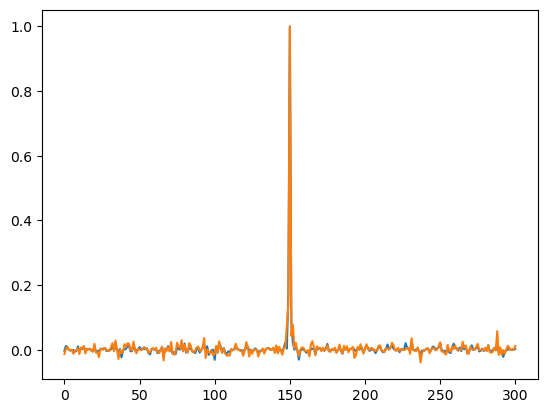

In [14]:
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])

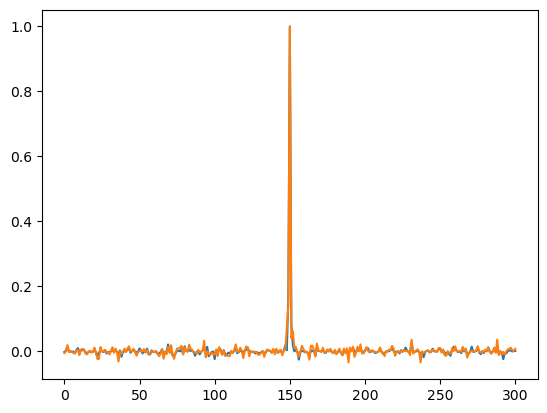

In [15]:
L = TrainLR(M_samples, H_samples, y_ref = y_ref, fit_intercept = False)
regr = L.quickTrain()

XL = XLR(regr, M_samples)
a_LR, stats_LR = XL.quick_analyze()

plt.plot(a_LR[0])
plt.plot(a_LR[1])